# Quanvolutional Neural Networks
Based on the PennyLane [demo](https://pennylane.ai/qml/demos/tutorial_quanvolution). Refer to this [paper](https://arxiv.org/abs/1904.04767).

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2025-03-11 10:59:22.511004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741651162.528193  136150 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741651162.533022  136150 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Model hyper-parameters

In [2]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "../adversarial-qml/demonstration_assets/quanvolution/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

MNIST dataset is loaded from _Keras_.

In [3]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size (increase the size in hyper-parameters for better performance)
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

## Quanvolutional kernel: a quantum circuit as a convolutional kernel

In [4]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [5]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

The quantum kernel is not trainable (here) and can be thought of as a _pre-processing_ step.

In [6]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
30/30        

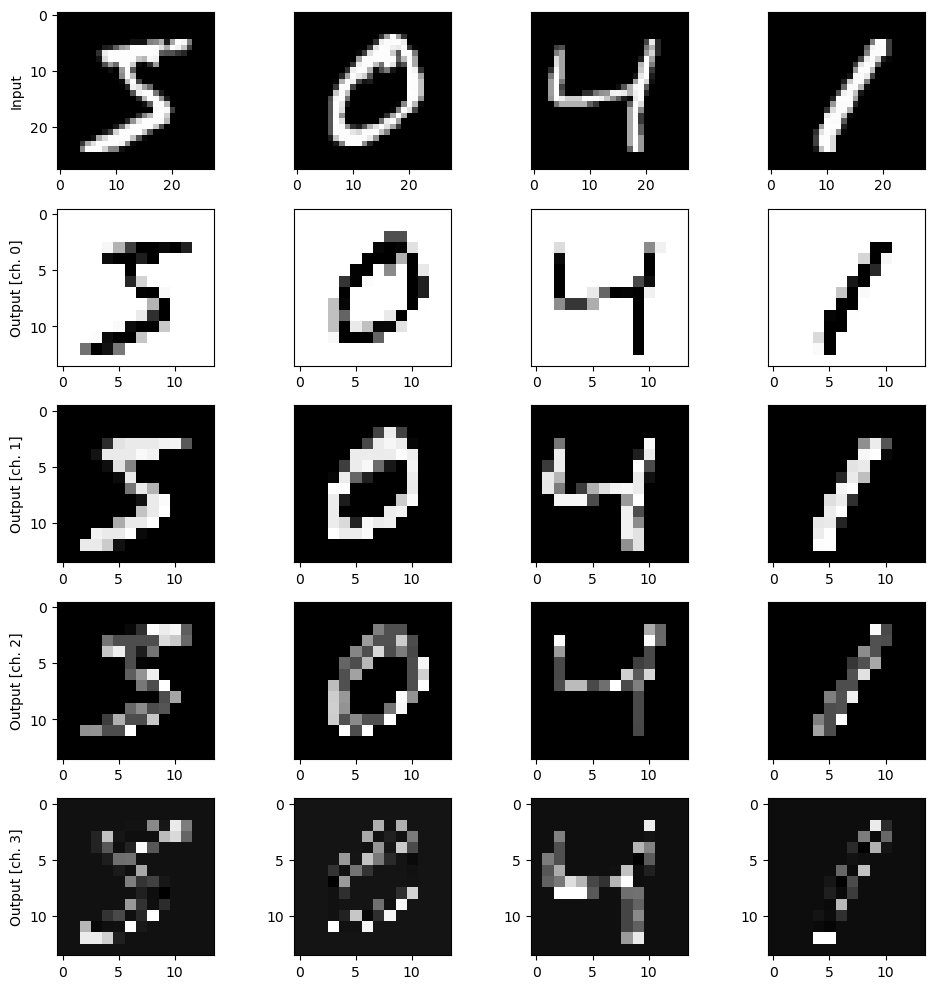

In [7]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

Notice that the images are downscaled (lower resolution). Different channels have different distortions introduced by the quantum kernel, but the overall structure is the same.

## Classification using a hybrid quantum-classical model

In [8]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam', # stochastic-gradient-descent
        loss="sparse_categorical_crossentropy", # cross-entropy
        metrics=["accuracy"],
    )
    return model

### Training

In [9]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30


I0000 00:00:1741651260.104317  136150 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11433 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:02:00.0, compute capability: 6.0
I0000 00:00:1741651260.735893  136241 service.cc:148] XLA service 0x7f9814005f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741651260.735923  136241 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-12GB, Compute Capability 6.0
I0000 00:00:1741651260.783247  136241 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-11 11:01:01.058472: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.3 which is older than the PTX compiler version 12.8.93. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forwa

13/13 - 2s - 144ms/step - accuracy: 0.1400 - loss: 2.7301 - val_accuracy: 0.1000 - val_loss: 2.3585
Epoch 2/30
13/13 - 0s - 8ms/step - accuracy: 0.2800 - loss: 1.9619 - val_accuracy: 0.2333 - val_loss: 2.1417
Epoch 3/30
13/13 - 0s - 7ms/step - accuracy: 0.5400 - loss: 1.6487 - val_accuracy: 0.3333 - val_loss: 1.9631
Epoch 4/30
13/13 - 0s - 7ms/step - accuracy: 0.7400 - loss: 1.3278 - val_accuracy: 0.3333 - val_loss: 1.8055
Epoch 5/30
13/13 - 0s - 6ms/step - accuracy: 0.8600 - loss: 1.0936 - val_accuracy: 0.4667 - val_loss: 1.6881
Epoch 6/30
13/13 - 0s - 7ms/step - accuracy: 0.9600 - loss: 0.9071 - val_accuracy: 0.4667 - val_loss: 1.5971
Epoch 7/30
13/13 - 0s - 21ms/step - accuracy: 0.9600 - loss: 0.7592 - val_accuracy: 0.5000 - val_loss: 1.5207
Epoch 8/30
13/13 - 0s - 7ms/step - accuracy: 1.0000 - loss: 0.6394 - val_accuracy: 0.5000 - val_loss: 1.4578
Epoch 9/30
13/13 - 0s - 7ms/step - accuracy: 1.0000 - loss: 0.5439 - val_accuracy: 0.5000 - val_loss: 1.4069
Epoch 10/30
13/13 - 0s - 6m

### Classical model for comparison

In [10]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 98ms/step - accuracy: 0.1400 - loss: 2.3108 - val_accuracy: 0.2667 - val_loss: 2.1630
Epoch 2/30
13/13 - 0s - 10ms/step - accuracy: 0.4200 - loss: 1.9197 - val_accuracy: 0.3333 - val_loss: 2.0012
Epoch 3/30
13/13 - 0s - 7ms/step - accuracy: 0.5200 - loss: 1.6366 - val_accuracy: 0.3667 - val_loss: 1.8583
Epoch 4/30
13/13 - 0s - 7ms/step - accuracy: 0.7600 - loss: 1.3995 - val_accuracy: 0.4000 - val_loss: 1.7332
Epoch 5/30
13/13 - 0s - 7ms/step - accuracy: 0.8800 - loss: 1.2014 - val_accuracy: 0.4333 - val_loss: 1.6272
Epoch 6/30
13/13 - 0s - 6ms/step - accuracy: 0.9000 - loss: 1.0373 - val_accuracy: 0.5333 - val_loss: 1.5398
Epoch 7/30
13/13 - 0s - 6ms/step - accuracy: 0.9400 - loss: 0.9018 - val_accuracy: 0.5667 - val_loss: 1.4683
Epoch 8/30
13/13 - 0s - 7ms/step - accuracy: 0.9600 - loss: 0.7897 - val_accuracy: 0.6000 - val_loss: 1.4093
Epoch 9/30
13/13 - 0s - 6ms/step - accuracy: 0.9800 - loss: 0.6963 - val_accuracy: 0.6333 - val_loss: 1.3599
Epoch 10/30
13/13

## Results

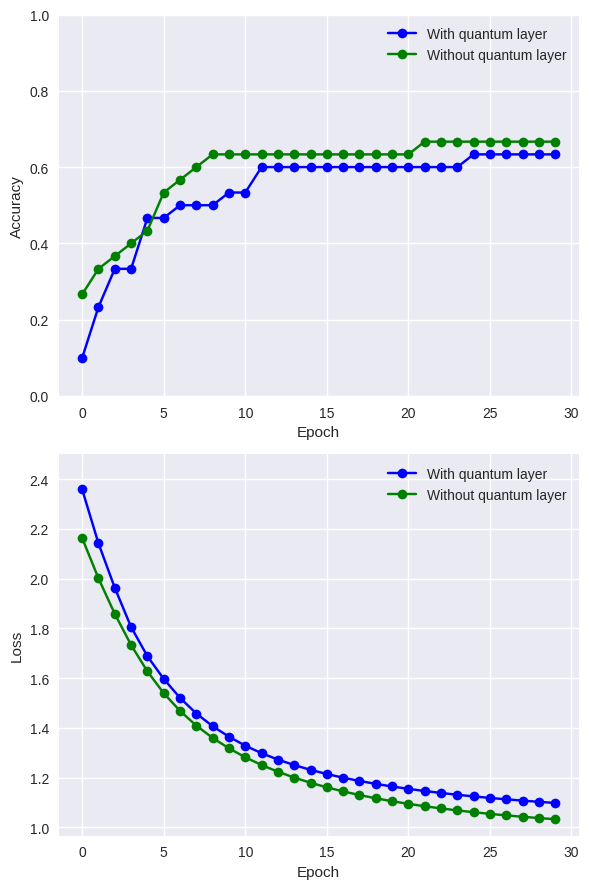

In [11]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

## Next Steps:
* Implement this model on [downscaled MNIST](https://pennylane.ai/datasets/downscaled-mnist).
* Make the quantum kernel trainable.
* Explore variational circuits instead of random circuit.